In [1]:
# This notebook shows how you can import lla into your project 
# It is assumed that your project already contains test_loader, model, criterion, optimizer
# It is shown how to create a metric object for loss evaluation and call viz_lla

# This library is distributed under Apache 2.0 license
# (c) Kryptonite, 2024

In [1]:
import copy
import argparse
import os
import random
import warnings
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

# import src_lla and main visualization functions
import src_lla
from src_lla import viz_lla, viz_esd, metrics

import matplotlib
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp_name = 'default'
data_path = '-1'
viz_dir = 'viz_results'
res_dir = 'analysis_results'
log_dir = None
weight_path = '-1'
num_plots = 2
num_per_plot = 2
epochs = None
lr = None
batch_size= 2048
viz_rate = 1
mode = 'add'
normalization = None
order = 2
dist = 1
steps = 40
viz_dev = True
cap_loss = None
axes = 'hessian'
eval_hessian = False
seed = None
raa = None

to_save = False
to_viz = True

In [3]:
if to_save:
    if not os.path.exists(viz_dir):
        os.makedirs(viz_dir)
    if not os.path.exists(res_dir):
        os.makedirs(res_dir)

In [4]:
seed = 42

if seed is not None:
    random.seed(seed)
    #if np is not None:
    #    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [5]:
cuda = True

In [6]:
if cuda:
    print('checking if cuda is available...')
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == 'cpu':
        print('Warning! --cuda was specified but cuda is not available!')
else:
    device = 'cpu'
print("Project running on device: ", device)

checking if cuda is available...
Warning! --cuda was specified but cuda is not available!
Project running on device:  cpu


In [7]:
allowed_axes = ['random', 'adam', 'hessian']

if axes not in allowed_axes:
    print('{} argument for axes is not supported, allowed {}!'.format(axes,allowed_axes))
    print('setting axes to random')
    axes = 'random'

if mode == 'adameq' or axes == 'adam':
    raise AttributeError('Adam axes analysis is not supported for evaluation, use train script to specify the optimizer')

if axes == 'random' and viz_dev:
    print('all_modes requires hessiann axes evaluation, setting axes to hessian!')
    axes = 'hessian'

if epochs is not None or lr is not None or log_dir is not None:
    warnings.warn('Some train flags are not supported for eval and will be ignored')

if normalization is None and order != 2:
    warnings.warn('Warning! Normalization order is specified but normalization is disabled!')

In [8]:
# Lenet implementation by lychengrex under MIT License
# original repo: https://github.com/lychengrex/LeNet-5-Implementation-Using-Pytorch/tree/master

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)  

In [9]:
mnist_test = datasets.MNIST(root='../data', train=False, download=True,transform=ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [15]:
model = LeNet()
model.load_state_dict(torch.load('example_weights/lenet_example.pth',map_location=device)) # load example pre-trained weights
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

# create metric object
x_plot, y_plot = iter(test_loader).__next__() # data that the evaluator will use when evaluating loss
metric = metrics.Loss(criterion, x_plot, y_plot,device)

cur_name = 'eval_' + exp_name
print('model and metric created successfully!')
#model.eval()

model and metric created successfully!


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


taking dirs from Hessian...
clipping loss at  10


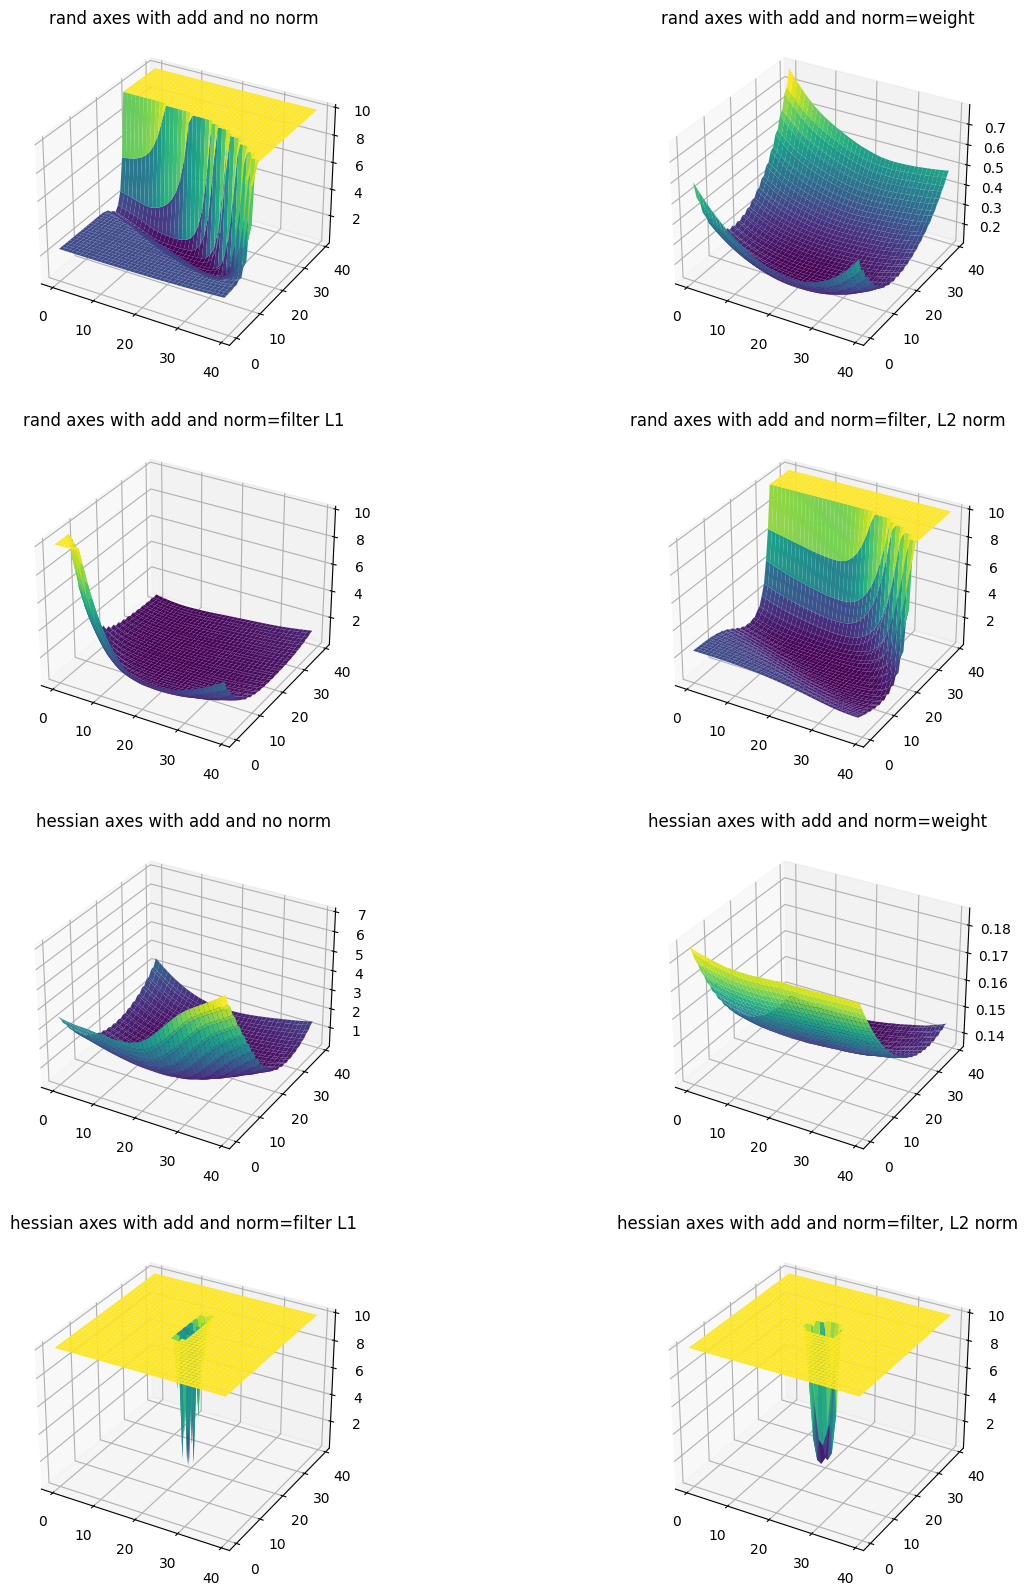

In [12]:
viz_lla(model=model, metric=metric, device=device, dist=dist, steps=steps, axes=axes, normalization=normalization, order=order, 
                    cur_name=cur_name, mode=mode, viz_dev=viz_dev, cap_loss=10, raa=raa, viz_dir=viz_dir, 
                    eval_hessian=eval_hessian, optimizer=None, to_save=to_save,to_viz=to_viz)

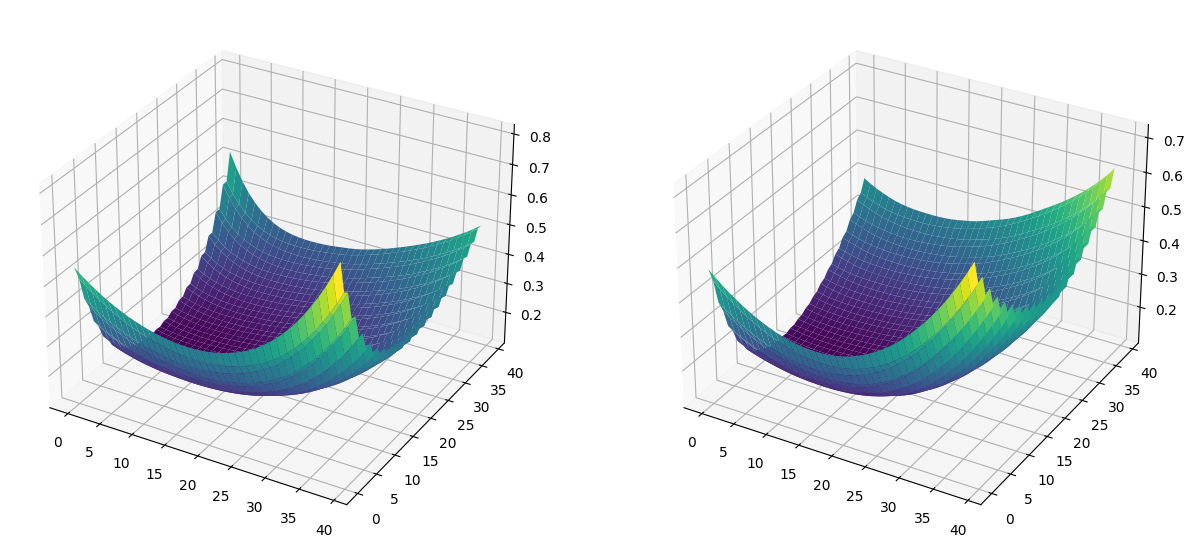

In [13]:
viz_lla(model=model, metric=metric, device=device, dist=dist, steps=steps, axes='random', num_plots=num_plots, normalization='weight', order=order, 
                    cur_name=cur_name, mode=mode, viz_dev=False, cap_loss=cap_loss, raa=raa, viz_dir=viz_dir, 
                    eval_hessian=eval_hessian, optimizer=None, to_save=to_save,to_viz=to_viz)

In [14]:
### pre-trained LeNet hessian

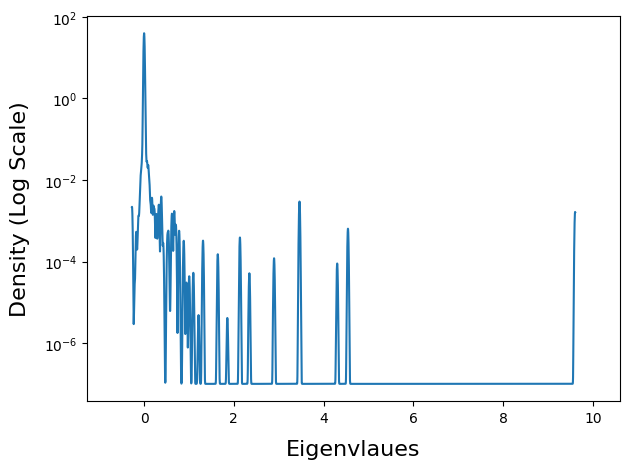

In [15]:
res = viz_esd(model,metric,esd=True,eigs=True,trace=True,calc_crit=True,to_save=False,to_viz=True,res_dir=res_dir,viz_dir=viz_dir)

In [16]:
# eigenvalues, eigenvectors
res[0], res[1][0][0][0]

([9.600095748901367, 4.297257423400879],
 tensor([[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]], device='cuda:0'))

In [17]:
# trace
res[2]

56.90314829349518

In [18]:
# criteria re, Khn
res[3], res[4]

(0.028126374, 0.22220787)

In [19]:
### back to random init

In [20]:
model = LeNet()
model.to(device)
print('model has been re-initialized')

model has been re-initialized


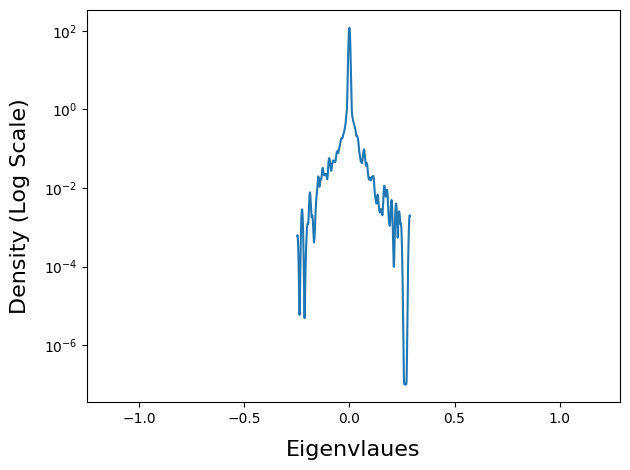

In [21]:
res = viz_esd(model,metric,esd=True,eigs=True,trace=True,calc_crit=True,to_save=False,to_viz=True,res_dir=res_dir,viz_dir=viz_dir)

In [22]:
# criteria re, Khn
res[3], res[4]

(0.86105233, 1.0334812)

In [23]:
####